# RCS of a corner reflector

<a href="https://rookiepeng.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20" align="left"></a>

<br></br>
This is example shows how to use [`RadarSimPy`](https://github.com/rookiepeng/radarsimpy) to simulate the RCS of an object based on its 3D model.

---

The corner reflector model is with `.stl`. It can be imported by using `meshio` module. 

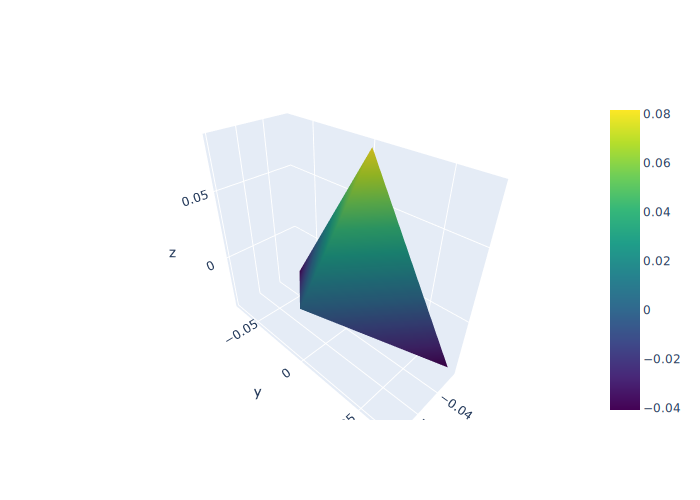

In [1]:
import meshio

import plotly.graph_objs as go
from IPython.display import SVG, display

mesh_data = meshio.read('../models/cr.stl')

fig = go.Figure()

fig.add_trace(go.Mesh3d(x=mesh_data.points[:, 0],
                        y=mesh_data.points[:, 1],
                        z=mesh_data.points[:, 2],
                        i=mesh_data.cells[0].data[:, 0],
                        j=mesh_data.cells[0].data[:, 1],
                        k=mesh_data.cells[0].data[:, 2],
                        intensity=mesh_data.points[:, 2],
                        colorscale='Viridis'
                        ))

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))

### RCS vs frequency

Define the basic parameters required in ray tracing.

- Observation angle `phi` (Degree)
- Observation angle `theta` (Degree)
- Frequency `freq` (Hz)
- Polarization `pol`
- Ray density `density` (number of rays per wavelength)

In [2]:
import time
import numpy as np

from radarsimpy.rt import rcs_sbr

phi = 0
theta = 90
freq = np.arange(1, 79, 1)*1e9
pol = [0, 1, 0]
density = 10

rcs = np.zeros_like(freq)

tic = time.time()
for f_idx, f in enumerate(freq):
    rcs[f_idx] = 10*np.log10(
        rcs_sbr('../models/cr.stl',
                f,
                phi,
                theta,
                pol=pol,
                density=density))
toc = time.time()

print('Exec time :'+str(toc-tic) + 's')

Exec time :15.675084352493286s


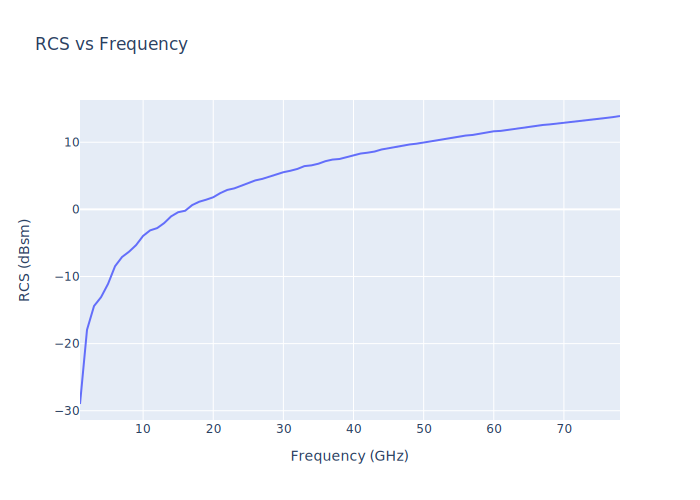

In [3]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=freq/1e9, y=rcs))

fig.update_layout(
    title='RCS vs Frequency',
    yaxis=dict(title='RCS (dBsm)'),
    xaxis=dict(title='Frequency (GHz)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))

### RCS vs observation angle

In [4]:
phi = np.arange(-90, 90, 0.5)
theta = 90
freq = 77e9
pol = [0, 0, 1]
density = 1

rcs = np.zeros_like(phi)

tic = time.time()
for phi_idx, phi_ang in enumerate(phi):
    rcs[phi_idx] = 10 * np.log10(
        rcs_sbr('../models/cr.stl',
                freq,
                phi_ang,
                theta,
                pol=pol,
                density=density))
toc = time.time()

print('Exec time :'+str(toc-tic) + 's')

Exec time :53.79998803138733s


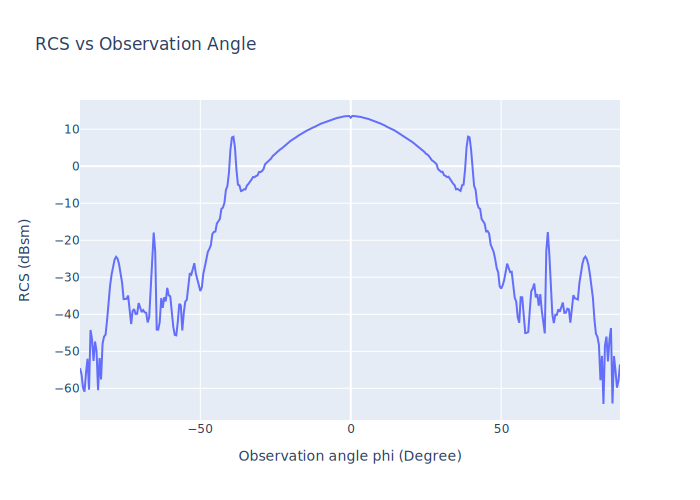

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=phi, y=rcs))

fig.update_layout(
    title='RCS vs Observation Angle',
    yaxis=dict(title='RCS (dBsm)'),
    xaxis=dict(title='Observation angle phi (Degree)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))